In [1]:
import torch
from torch.backends import cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import *
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from datetime import datetime as dt
from datetime import timedelta

from config.config_cloud import Config_cloud

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True
cudnn.deterministic = True

In [2]:
Cfg = Config_cloud()

In [3]:
data = pd.read_pickle('data/data_test.pkl')
cloud_clip = np.load("data/test_cloud_clip.npy")
cloud_all = np.stack(list(data['cloud'].values()))
data_met = pd.read_pickle('data/data_test_met.pkl')

In [4]:
root_path = "/mnt/nasbi/no-backups/datasets/video_datasets/cloud_video/"

In [5]:
import segmentation_models_pytorch as smp
in_channels = 27
cloud2cloud = smp.PSPNet(encoder_name='resnet34', classes=4, encoder_weights='imagenet')
cloud2cloud.encoder.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)

cloud2cloud.load_state_dict(torch.load('save_model/20.pth'))
cloud2cloud = cloud2cloud.cuda()
cloud2cloud.eval()

PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(27, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [6]:
submit = []
for i in range(len(cloud_clip)):
#for i in range(1):
    cloud_list = cloud_clip[i] 
    end_id =  str(cloud_list[-1])
    year, month, day, hour = end_id[:4], end_id[4:6], end_id[6:8], end_id[8:10]
    
    x = []
    for cloud_id in cloud_list:
        cloud_x = data['cloud'][str(cloud_id)]/255
        x.append(cloud_x)
    x = np.stack(x)

    end_id =  str(cloud_list[-1])
    cloud_met = data_met['HGTs'][end_id]
    x = np.concatenate([x,cloud_met],axis=0)
    x = torch.from_numpy(x).type(torch.float32)
    x = x.unsqueeze(0)  
    x = x.cuda()

    output = cloud2cloud(x)
    output = output.cpu().detach().numpy()[0]
    
    img18_all = []
    for img in output:
        img = cv2.resize(img,(512,640))
        img = img[40:460, 130:470]
        img18_all.append(img)
        
    img18_all = np.stack(img18_all)
    img18_all = np.clip(img18_all, 0, 1)

    init_16 = dt(2016,int(month),int(day), int(hour), 0, 0)
    init_17 = dt(2017,int(month),int(day), int(hour), 0, 0)
    
    group = []
    for i in range(4):
        try:
            date_16 = init_16 + timedelta(hours=(i+1)*6)
            img16_path = root_path+"train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                        format(year=date_16.year, month=date_16.month, day=date_16.day, hour=date_16.hour)
            img16 = cv2.imread(img16_path,0)[40:460, 130:470]/255
        except:
            date_16 = init_16 + timedelta(hours=(i+1)*6+1)
            img16_path = root_path+"train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                        format(year=date_16.year, month=date_16.month, day=date_16.day, hour=date_16.hour)
            img16 = cv2.imread(img16_path,0)[40:460, 130:470]/255
        
        try:
            date_17 = init_17 + timedelta(hours=(i+1)*6)
            img17_path = root_path+"train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                        format(year=date_17.year, month=date_17.month, day=date_17.day, hour=date_17.hour)
            img17 = cv2.imread(img17_path,0)[40:460, 130:470]/255
        except:
            date_17 = init_17 + timedelta(hours=(i+1)*6+1)
            img17_path = root_path+"train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                        format(year=date_17.year, month=date_17.month, day=date_17.day, hour=date_17.hour)
            img17 = cv2.imread(img17_path,0)[40:460, 130:470]/255
        '''
        print(f'18_end_id:{end_id}')
        print(f'date_16:{date_16}')
        print(f'date_17:{date_17}')
        '''
        img18 = img18_all[i]
        '''
        plt.imshow(img16,cmap='gray')
        plt.show()
        plt.imshow(img17,cmap='gray')
        plt.show()
        '''
        diff_16_17 = abs(img17-img16)
        diff_16_17[diff_16_17>0.1] = 1
        diff_16_17[diff_16_17<0.1] = 0
        diff_16_17 = 1-diff_16_17

        img_16_17 = (img17+img16)*diff_16_17/2
        '''
        plt.figure(figsize=(8,8))
        plt.imshow(img_16_17,cmap='gray')
        plt.show()
        '''

        diff_18 = abs(img_16_17-img18)
        diff_18[diff_18>0.05] = 1
        diff_18[diff_18<0.05] = 0
        '''
        plt.figure(figsize=(8,8))
        plt.imshow(diff_18,cmap='gray')
        plt.show()
        '''
        img18_fuse = img18*diff_18+img_16_17*(1-diff_18)
        '''
        plt.figure(figsize=(8,8))
        plt.imshow(img18_fuse,cmap='gray')
        plt.show()
        plt.figure(figsize=(8,8))
        plt.imshow(img18,cmap='gray')
        plt.show()
        '''
        group.append(img18_fuse)
    
    group = np.vstack(group)
    submit.append(group)
    
submit = np.vstack(submit)
        


In [7]:
submit = submit*255
print(np.max(submit))
print(np.min(submit))
submit = submit.astype(np.int)
submit = pd.DataFrame(submit)

255.0
0.0


In [8]:
submit.head()

,0,1,2,3,4,5,6,7,8,9,...,330,331,332,333,334,335,336,337,338,339
0,174,173,170,171,174,178,180,181,181,180,...,145,146,146,147,148,148,149,150,151,151
1,172,175,172,169,174,178,180,180,181,180,...,145,146,146,147,148,149,149,150,151,152
2,173,177,175,165,170,176,179,180,179,179,...,145,146,147,147,148,149,150,150,151,152
3,173,179,176,166,168,175,179,179,178,176,...,145,146,147,148,148,149,150,151,151,152
4,175,176,177,170,168,174,178,178,176,176,...,146,146,147,148,149,149,150,151,151,152


In [9]:
submit.to_csv('submit.csv',header=False, index=True)

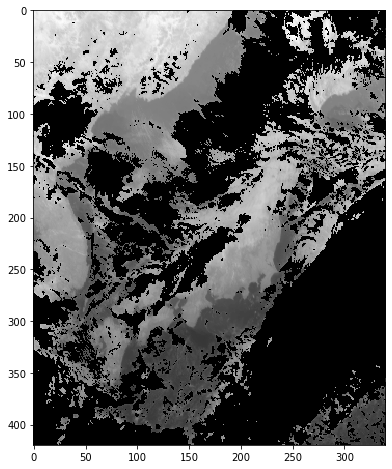

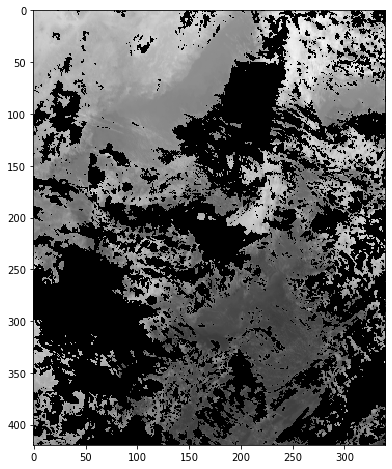

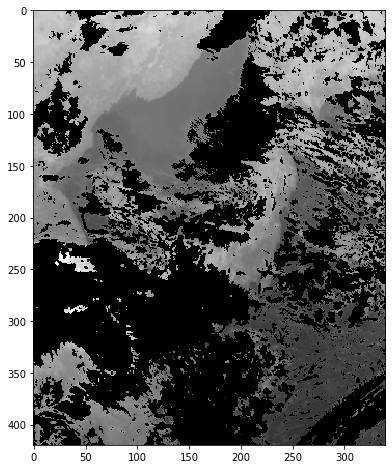

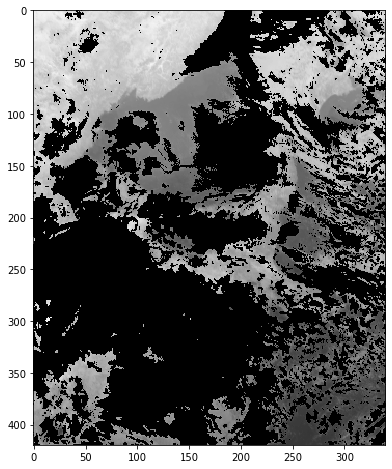

In [57]:
for j in range(4):
    img16 = cv2.imread(history_16[j],0)[40:460, 130:470]/255
    img17 = cv2.imread(history_17[j],0)[40:460, 130:470]/255
    '''
    plt.imshow(img16,cmap='gray')
    plt.show()
    plt.imshow(img17,cmap='gray')
    plt.show()
    '''
    diff_16_17 = abs(img17-img16)
    diff_16_17[diff_16_17>0.1] = 1
    diff_16_17[diff_16_17<0.1] = 0
    diff_16_17 = 1-diff_16_17

    img_16_17 = (img17+img16)*diff_16_17/2
    '''
    plt.figure(figsize=(8,8))
    plt.imshow(img_16_17,cmap='gray')
    plt.show()
    '''
    
    diff_18 = abs(img_16_17-img18)
    diff_18[diff_18>0.15] = 1
    diff_18[diff_18<0.15] = 0
    diff_18 = 1-diff_18

In [37]:
date = init_date + timedelta(hours=6)

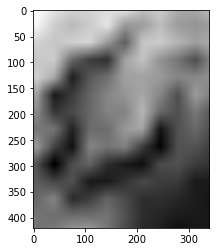

In [10]:
plt.imshow(img,cmap='gray')

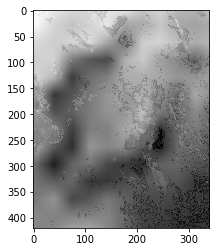

In [14]:
plt.imshow(img18_fuse,cmap='gray')

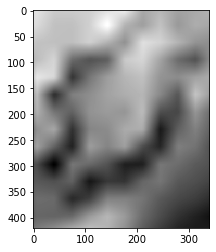

In [9]:
plt.imshow(img,cmap='gray')

In [9]:
submit = []
for i in range(len(cloud_clip)):
    cloud_list = cloud_clip[i]
    
    x = []
    for cloud_id in cloud_list:
        cloud_x = data['cloud'][str(cloud_id)]/255
        x.append(cloud_x)
    x = np.stack(x)

    end_id =  str(cloud_list[-1])
    cloud_met = data_met['HGTs'][end_id]
    x = np.concatenate([x,cloud_met],axis=0)
    x = torch.from_numpy(x).type(torch.float32)
    x = x.unsqueeze(0)  
    x = x.cuda()

    output = cloud2cloud(x)
    output = output.cpu().detach().numpy()[0]
    
    group = []
    for img in output:
        img = cv2.resize(img,(512,640))
        img = img[40:460, 130:470]
        group.append(img)
        #plt.figure(figsize=(8,8))
        #plt.imshow(img,cmap='gray')
        
    group = np.vstack(group)
    group = np.clip(group, 0, 1)
    submit.append(group)
    
submit = np.vstack(submit)

In [ ]:
submit = []
for i in range(len(cloud_clip)):
    cloud_list = cloud_clip[i] 
    end_id =  str(cloud_list[-1])
    year, month, day, hour = end_id[:4], end_id[4:6], end_id[6:8], end_id[8:10]
    
    x = []
    for cloud_id in cloud_list:
        cloud_x = data['cloud'][str(cloud_id)]/255
        x.append(cloud_x)
    x = np.stack(x)

    end_id =  str(cloud_list[-1])
    cloud_met = data_met['HGTs'][end_id]
    x = np.concatenate([x,cloud_met],axis=0)
    x = torch.from_numpy(x).type(torch.float32)
    x = x.unsqueeze(0)  
    x = x.cuda()

    output = cloud2cloud(x)
    output = output.cpu().detach().numpy()[0]
    
    img18_all = []
    for img in output:
        img = cv2.resize(img,(512,640))
        img = img[40:460, 130:470]
        img18_all.append(img)
        
    img18_all = np.stack(img18_all)
    img18_all = np.clip(img18_all, 0, 1)
     
    history_16 = []
    history_17 = []
    
    init_16 = dt(2016,int(month),int(day), int(hour), 0, 0)
    init_17 = dt(2017,int(month),int(day), int(hour), 0, 0)
    for i in range(6,25,6):
        date_16 = init_16 + timedelta(hours=i)
        date_17 = init_17 + timedelta(hours=i)
        history_16.append(root_path+"train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                        format(year=date_16.year, month=date_16.month, day=date_16.day, hour=date_16.hour))
        history_17.append(root_path+"train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                format(year=date_17.year, month=date_17.month, day=date_17.day, hour=date_17.hour))
    
    group = []
    for j in range(4):
        img16 = cv2.imread(history_16[j],0)[40:460, 130:470]/255
        img17 = cv2.imread(history_17[j],0)[40:460, 130:470]/255
        img18 = img18_all[j]
        '''
        plt.imshow(img16,cmap='gray')
        plt.show()
        plt.imshow(img17,cmap='gray')
        plt.show()
        '''
        diff_16_17 = abs(img17-img16)
        diff_16_17[diff_16_17>0.1] = 1
        diff_16_17[diff_16_17<0.1] = 0
        diff_16_17 = 1-diff_16_17

        img_16_17 = (img17+img16)*diff_16_17/2
        '''
        plt.figure(figsize=(8,8))
        plt.imshow(img_16_17,cmap='gray')
        plt.show()
        '''

        diff_18 = abs(img_16_17-img18)
        diff_18[diff_18>0.1] = 1
        diff_18[diff_18<0.1] = 0
        diff_18 = 1-diff_18
        '''
        plt.figure(figsize=(8,8))
        plt.imshow(diff_18,cmap='gray')
        plt.show()
        '''
        img18_fuse = img_16_17*diff_18+img18*(1-diff_18)
        '''
        plt.figure(figsize=(8,8))
        plt.imshow(img18_fuse,cmap='gray')
        plt.show()
        plt.figure(figsize=(8,8))
        plt.imshow(img18,cmap='gray')
        plt.show()
        '''
        group.append(img18_fuse)
    
    group = np.vstack(group)
    submit.append(group)
    
submit = np.vstack(submit)
        
